## faiss Kmeans

In [2]:
import faiss
import torch

import faiss
import numpy as np

# 生成一些随机数据
data = torch.rand(20,2).cuda()
print("原始数据：", data)
shape = data.shape
# 设置 K-means 聚类的参数
num_clusters = 3
kmeans = faiss.Kmeans(d=1, k=num_clusters, niter=20, verbose=True, gpu=True)

# 训练 K-means 模型
data = torch.flatten(data).unsqueeze(1)
# print("展开数据：", data)
tmp = data.cupy()
kmeans.train(tmp)
# 获取聚类中心
centroids = kmeans.centroids

# 将数据分配到最近的聚类中心
D, I = kmeans.index.search(data, 1)

# 将所有数据点转换为其对应的聚类中心
transformed_data = centroids[I.flatten()]
# print("聚类结果：", transformed_data)
data = torch.tensor(transformed_data).reshape(shape)

print("转换后的数据：", data)

原始数据： tensor([[0.4347, 0.9081],
        [0.0365, 0.0571],
        [0.4665, 0.1870],
        [0.3527, 0.3669],
        [0.2441, 0.3459],
        [0.0405, 0.8337],
        [0.7251, 0.7827],
        [0.0358, 0.5994],
        [0.2850, 0.2483],
        [0.0219, 0.4253],
        [0.7735, 0.6374],
        [0.7444, 0.4029],
        [0.6742, 0.0352],
        [0.5115, 0.6777],
        [0.4224, 0.8974],
        [0.3544, 0.1033],
        [0.2920, 0.6789],
        [0.2429, 0.2967],
        [0.5074, 0.3509],
        [0.0820, 0.6922]], device='cuda:0')


AttributeError: 'Tensor' object has no attribute 'cupy'

## likelihood 

In [1]:
import torch
from ctrlg import HMM

hmm_model_path = './distillation/workspace/models/hmm_gpt2-large_4096/checkpoint-90'
hmm_model_path = 'ctrlg/hmm_gpt2-large_common-gen_4096'
data_path = './distillation/workspace/hmm_data/gpt2-large/gpt2-large.dev'
hmm_model = HMM.from_pretrained(hmm_model_path, map_location='cpu').to('cuda:0')
dev_data = torch.load(data_path)

dev_size = dev_data.shape[0]
dev_ll = hmm_model.loglikelihood(dev_data, batch_size=256)
dev_ll = dev_ll.item() / dev_size
msg = f'test ll\t{dev_ll}'
print(msg)

# linear quantization
cluster = 8 - 1
alpha_flow, beta_flow, gamma_flow = hmm_model.alpha_exp, hmm_model.beta.exp(), hmm_model.gamma.exp()
scale = torch.max(alpha_flow) / cluster
alpha_flow.div_(scale).round_().clamp_(0, cluster)
scale = torch.max(beta_flow) / cluster
beta_flow.div_(scale).round_().clamp_(0, cluster)
scale = torch.max(gamma_flow) / cluster
gamma_flow.div_(scale).round_().clamp_(0, cluster)
# alpha_flow = torch.clamp(alpha_flow.mul(255).round(), 0, 255)
# beta_flow = torch.clamp(beta_flow.mul(255).round(), 0, 255)
# gamma_flow = torch.clamp(gamma_flow.mul(255).round(), 0, 255)
# normalization
pseudocount = 0.001
alpha_flow += pseudocount / alpha_flow.shape[-1]
beta_flow += pseudocount / beta_flow.shape[-1]
gamma_flow += pseudocount / gamma_flow.shape[-1]
alpha_flow.div_(torch.sum(alpha_flow, dim=-1, keepdim=True))
beta_flow.div_(torch.sum(beta_flow, dim=-1, keepdim=True)).log_()
gamma_flow.div_(torch.sum(gamma_flow, dim=0, keepdim=True)).log_()
hmm_model.update_params(alpha_flow, beta_flow, gamma_flow)

# test likelihood
dev_ll = hmm_model.loglikelihood(dev_data, batch_size=256)
dev_ll = dev_ll.item() / dev_size
msg = f'test ll\t{dev_ll}'
print(msg)

## QAT plt

#### likelihood

In [1]:
import io

# tmp = [(10, 1), (5, 2), (4, 5), (4, 10), (4, 20)]
# x = [0]
# for step, size in tmp:
#     for i in range(step):
#         x.append(x[-1] + size)

data0 = '''
0	-1.0	-100.711265625
1	-73.54259375	-88.7300234375
2	-71.7558125	-86.63284375
3	-70.99565625	-85.191625
4	-71.356578125	-84.01884375
5	-71.4615	-83.2676328125
6	-69.538703125	-82.424390625
7	-68.10375	-81.839265625
8	-68.2370234375	-81.0966875
9	-68.6251171875	-80.753
10	-66.807390625	-80.297171875
11	-67.7275	-79.951859375
12	-67.945453125	-79.72709375
13	-68.1503359375	-79.511796875
14	-68.8794140625	-79.1562421875
15	-67.8570390625	-79.032671875
16	-66.14396875	-78.96503125
17	-67.051359375	-78.607
18	-66.2728203125	-78.799765625
19	-67.601390625	-78.528625
20	-67.456421875	-78.4278125
21	-67.037421875	-78.2909609375
22	-65.946109375	-78.2563203125
23	-66.172328125	-78.166546875
24	-67.3858828125	-77.9953515625
25	-67.9294609375	-78.1392109375
26	-66.8175	-77.974671875
27	-66.057140625	-78.0171953125
28	-66.566546875	-77.85940625
29	-66.9563046875	-77.938453125
30	-65.7178203125	-77.839078125
31	-66.704046875	-77.796921875
32	-67.033390625	-77.796484375
33	-67.40909375	-77.916859375
34	-68.427265625	-77.780796875
35	-67.347375	-77.752234375
36	-65.93178125	-77.863
37	-66.7204609375	-77.4991640625
38	-66.0520078125	-77.84178125
39	-67.2935625	-77.7372265625
40	-67.197828125	-77.685125
41	-66.8371875	-77.5833359375
42	-65.901734375	-77.646359375
43	-65.98609375	-77.57696875
44	-67.341515625	-77.4811640625
45	-67.8753046875	-77.6489765625
46	-66.867546875	-77.5305546875
47	-65.940484375	-77.5285
48	-66.60978125	-77.3641015625
49	-67.204703125	-77.403921875
50	-65.817328125	-77.2976875
51	-66.8587578125	-77.36490625
52	-67.2669375	-77.4543125
53	-67.5349140625	-77.564625
54	-68.615421875	-77.41084375
55	-67.539734375	-77.50596875
56	-66.051671875	-77.5742734375
57	-66.8261328125	-77.2173984375
58	-66.288296875	-77.5352265625
59	-67.528203125	-77.5040625
60	-67.354328125	-77.443078125
61	-67.048765625	-77.397546875
62	-66.0309609375	-77.44190625
63	-66.1933125	-77.38096875
64	-67.533796875	-77.30921875
65	-68.1113515625	-77.4237890625
66	-66.9495625	-77.4437265625
67	-66.156359375	-77.382296875
68	-66.83571875	-77.1968125
69	-67.3173125	-77.325171875
70	-65.9406796875	-77.29525
71	-66.915796875	-77.3965
72	-67.3534296875	-77.363421875
73	-67.52278125	-77.502671875
74	-68.78890625	-77.407765625
75	-67.63128125	-77.427359375
76	-66.1709375	-77.493265625
77	-67.043484375	-77.2332109375
78	-66.3884921875	-77.56484375
79	-67.5820390625	-77.394734375
80	-67.4051015625	-77.353265625
81	-67.2070859375	-77.388484375
82	-66.0781875	-77.4580390625
83	-66.313859375	-77.361640625
84	-67.618421875	-77.2828203125
85	-68.3034140625	-77.3852890625
86	-67.0021328125	-77.3168203125
87	-66.2229375	-77.3405703125
88	-66.869421875	-77.1287890625
89	-67.400265625	-77.285328125
90	-66.0606015625	-77.2269375
91	-67.063796875	-77.2678046875
92	-67.552078125	-77.36071875
93	-67.6234609375	-77.466453125
94	-68.8643046875	-77.327125
95	-67.7497890625	-77.4105390625
96	-66.2255703125	-77.4856015625
97	-67.1966640625	-77.192671875
98	-66.48803125	-77.504375
99	-67.7058828125	-77.3880859375
100	-67.475875	-77.329328125
'''

data1 = '''
0	-1.0	-100.711265625
1	-84.8413125	-108.199640625
2	-82.0466015625	-107.7170625
3	-81.0912734375	-106.7064140625
4	-81.5400625	-106.3653203125
5	-81.9045703125	-106.2921171875
6	-80.1909609375	-106.0205
7	-79.6246484375	-105.9111875
8	-80.0682890625	-105.5016875
9	-80.5090859375	-105.41
10	-79.1600859375	-105.397296875
11	-79.902953125	-105.3546640625
12	-80.4061015625	-105.185953125
13	-81.029453125	-104.756953125
14	-82.3429296875	-104.952046875
15	-81.315671875	-104.6919375
16	-79.50415625	-105.0250625
17	-80.847265625	-104.79853125
18	-79.917625	-104.7151953125
19	-81.55953125	-104.6349375
20	-81.74915625	-104.612421875
21	-80.999640625	-104.5732890625
22	-80.5663515625	-104.50171875
23	-80.6913125	-104.541265625
24	-81.973578125	-104.239671875
25	-82.984546875	-104.5356875
26	-80.75203125	-104.4669375
27	-80.3256796875	-104.4674921875
28	-81.458984375	-104.2544140625
29	-81.774234375	-104.215078125
30	-80.49703125	-104.0161953125
31	-81.333453125	-103.9618125
32	-81.6251796875	-104.032796875
33	-82.350328125	-104.00003125
34	-84.023859375	-103.94159375
35	-82.520671875	-103.737875
36	-80.5548671875	-103.892578125
37	-81.48084375	-103.5459296875
38	-81.119078125	-103.8329140625
39	-82.296609375	-103.79996875
40	-82.255171875	-103.69275
41	-82.6254140625	-103.915421875
42	-81.527984375	-103.9055
43	-81.923	-103.82159375
44	-83.0500546875	-103.5916640625
45	-83.7671875	-103.7253203125
46	-81.8849140625	-103.637796875
47	-81.54325	-103.511140625
48	-82.6764375	-103.373703125
49	-82.6226796875	-103.377609375
50	-81.49353125	-103.280546875
51	-82.58171875	-103.43715625
52	-82.505078125	-103.424578125
53	-83.562703125	-103.482171875
54	-85.156796875	-103.476
55	-83.797921875	-103.526703125
56	-81.63778125	-103.359734375
57	-82.380390625	-103.452703125
58	-82.41603125	-103.486328125
59	-83.3903046875	-103.296296875
60	-83.63365625	-103.35840625
61	-83.4288125	-103.510859375
62	-82.446921875	-103.42075
63	-82.733046875	-103.40203125
64	-83.88553125	-103.1062265625
65	-85.156328125	-103.29496875
66	-83.4417578125	-103.007109375
67	-81.8842109375	-102.99009375
68	-82.864546875	-102.9091171875
69	-83.6770625	-102.973921875
70	-82.29240625	-102.801765625
71	-83.364921875	-103.0865
72	-83.287625	-103.1746015625
73	-84.071125	-103.187625
74	-85.615203125	-102.908078125
75	-83.733375	-102.9222578125
76	-82.2425546875	-102.985171875
77	-83.140484375	-102.960078125
78	-82.61421875	-103.1288515625
79	-83.95675	-102.962984375
80	-84.05003125	-102.9708203125
81	-83.882875	-102.764890625
82	-82.8967890625	-102.891296875
83	-82.903609375	-102.981765625
84	-84.7420234375	-102.9224375
85	-85.513375	-103.154109375
86	-83.291375	-102.976625
87	-82.481734375	-102.97628125
88	-83.6772109375	-102.604703125
89	-84.17946875	-102.6230859375
90	-82.31428125	-102.709796875
91	-84.134484375	-102.6816953125
92	-83.94584375	-102.55303125
93	-85.2165390625	-102.630640625
94	-86.062890625	-102.4125078125
95	-84.43996875	-102.619421875
96	-82.6896953125	-102.538640625
97	-83.558015625	-102.4630625
98	-82.832109375	-102.62521875
99	-84.3562578125	-102.454375
100	-84.2685078125	-102.543359375
'''

data2 = '''
0	-1.0	-100.711265625
1	-73.5706875	-88.757375
2	-83.7715078125	-106.6756796875
3	-71.511015625	-87.5017578125
4	-81.63096875	-103.1354609375
5	-72.947046875	-86.840484375
6	-79.42884375	-101.928671875
7	-70.284125	-86.2195
8	-79.6070078125	-100.9981875
9	-71.9985859375	-85.918671875
10	-78.74678125	-100.30021875
11	-71.507578125	-85.482578125
12	-80.5093359375	-99.99203125
13	-72.235953125	-85.370765625
14	-82.2765859375	-99.56715625
15	-72.209984375	-84.9262578125
16	-79.41221875	-99.6397265625
17	-71.55803125	-84.8251796875
18	-79.516625	-99.166578125
19	-72.4208828125	-84.782328125
20	-80.965671875	-98.86628125
21	-72.046703125	-84.3883828125
22	-79.7141875	-98.51171875
23	-71.181046875	-84.315078125
24	-81.669265625	-98.108046875
25	-73.032109375	-84.418625
26	-80.508765625	-97.98740625
27	-70.935734375	-84.102234375
28	-81.097890625	-97.5507109375
29	-72.4987109375	-84.0696328125
30	-79.9750546875	-97.5814296875
31	-72.112125	-83.96503125
32	-81.2708125	-97.353703125
33	-72.66015625	-83.9693515625
34	-83.6515703125	-97.3575546875
35	-72.7970859375	-83.787
36	-79.653078125	-97.356140625
37	-72.1126875	-83.6202578125
38	-80.2694375	-97.092703125
39	-72.8911875	-83.65171875
40	-81.7803828125	-97.013296875
41	-72.3075390625	-83.4931953125
42	-80.60265625	-96.9485859375
43	-71.520078125	-83.45775
44	-82.455625	-96.6041484375
45	-73.51665625	-83.48265625
46	-81.51828125	-96.6281484375
47	-71.2180625	-83.500859375
48	-81.767328125	-96.0706875
49	-72.88121875	-83.2268203125
50	-80.79415625	-96.5134375
51	-72.406625	-83.3542265625
52	-82.3023203125	-96.428078125
53	-72.861203125	-83.3369375
54	-84.403390625	-96.328765625
55	-72.813578125	-83.20065625
56	-80.9625546875	-96.586640625
57	-72.3248515625	-83.1228984375
58	-80.9506015625	-96.6909296875
59	-73.052546875	-83.2413828125
60	-82.7725859375	-96.368078125
61	-72.594421875	-82.9136640625
62	-81.13878125	-96.221625
63	-71.522953125	-82.99534375
64	-83.21065625	-95.9333359375
65	-73.7774296875	-83.08603125
66	-82.419453125	-96.211
67	-71.2997734375	-83.01484375
68	-82.3406875	-95.813265625
69	-72.902703125	-82.893125
70	-80.9641796875	-95.8159375
71	-72.58978125	-82.92275
72	-82.653234375	-96.18675
73	-72.9152890625	-83.12671875
74	-84.969796875	-96.1708203125
75	-73.004140625	-82.98225
76	-81.031859375	-96.47203125
77	-72.289640625	-82.85928125
78	-81.551625	-96.2941875
79	-72.933671875	-83.0428046875
80	-83.345703125	-96.25346875
81	-72.711390625	-82.781625
82	-81.5730703125	-96.1362734375
83	-71.6977421875	-82.753984375
84	-83.378984375	-95.5934921875
85	-73.8500546875	-82.767421875
86	-82.6717578125	-95.58278125
87	-71.3951328125	-82.647703125
88	-82.428015625	-95.306796875
89	-72.92225	-82.642484375
90	-81.435609375	-95.436765625
91	-72.50978125	-82.6467578125
92	-82.765875	-95.573234375
93	-72.979296875	-82.653640625
94	-85.289375	-95.5208046875
95	-73.150109375	-82.615171875
96	-81.4144453125	-95.9240546875
97	-72.358953125	-82.56659375
98	-81.634890625	-95.728953125
99	-73.10453125	-82.5837578125
100	-83.147703125	-95.60165625
'''

data5 = '''
0	-1.0	-100.711265625
1	-73.57540625	-88.799953125
2	-71.804046875	-86.65225
3	-71.0788984375	-85.1854453125
4	-71.387796875	-84.038515625
5	-81.20434375	-100.6921328125
6	-70.347234375	-85.32790625
7	-69.278609375	-83.803625
8	-69.7076484375	-82.704328125
9	-70.004109375	-82.251484375
10	-75.817734375	-97.003296875
11	-70.0511484375	-83.9445546875
12	-70.3726484375	-82.6680859375
13	-70.39803125	-82.15390625
14	-71.2043046875	-81.46665625
15	-77.4926875	-95.62396875
16	-69.050953125	-83.215484375
17	-70.0046796875	-81.9821640625
18	-69.0280234375	-81.623671875
19	-70.2673515625	-81.0295625
20	-77.4070703125	-94.41821875
21	-70.352265625	-82.548453125
22	-69.33384375	-81.643703125
23	-69.257484375	-81.0938125
24	-70.261578125	-80.647359375
25	-79.308140625	-94.09365625
26	-70.245828125	-82.188796875
27	-69.347203125	-81.372953125
28	-69.837140625	-80.6988125
29	-70.31525	-80.503171875
30	-76.5590390625	-93.4946171875
31	-70.3651484375	-81.913765625
32	-70.554578125	-81.126984375
33	-70.827953125	-80.7551484375
34	-71.753296875	-80.3015703125
35	-79.35821875	-93.3070546875
36	-69.695484375	-81.80103125
37	-70.475953125	-80.924078125
38	-69.458140625	-80.784375
39	-70.73121875	-80.472984375
40	-79.539265625	-93.4198125
41	-70.838046875	-81.7165
42	-69.725046875	-81.0640390625
43	-69.7004609375	-80.6180703125
44	-70.6062109375	-80.191765625
45	-80.74721875	-93.501640625
46	-70.7989140625	-81.50796875
47	-69.710953125	-80.778609375
48	-70.130125	-80.278390625
49	-70.614265625	-80.10040625
50	-77.813828125	-93.104203125
51	-70.8858125	-81.393671875
52	-70.9900859375	-80.76228125
53	-70.915359375	-80.480984375
54	-72.054890625	-80.166
55	-80.3262109375	-93.018890625
56	-69.754546875	-81.420578125
57	-70.6965625	-80.639203125
58	-69.718890625	-80.475953125
59	-70.9595859375	-80.1313828125
60	-80.3870390625	-93.0566640625
61	-71.1362265625	-81.17096875
62	-69.938921875	-80.6673984375
63	-69.8651640625	-80.250671875
64	-70.908609375	-79.975875
65	-81.85	-93.141296875
66	-70.8546484375	-81.2975703125
67	-69.7565078125	-80.609125
68	-70.344296875	-80.195609375
69	-70.983125	-80.00996875
70	-78.71715625	-92.6589296875
71	-70.8142890625	-81.209296875
72	-71.0943671875	-80.5771640625
73	-71.102984375	-80.41765625
74	-72.1815859375	-80.058796875
75	-80.729390625	-92.78296875
76	-69.9273828125	-81.37459375
77	-70.9643125	-80.5142734375
78	-69.882734375	-80.522703125
79	-71.0888984375	-80.1262109375
80	-80.731078125	-93.18959375
81	-71.23309375	-81.180640625
82	-69.9908984375	-80.5835859375
83	-69.9534921875	-80.154375
84	-71.0809453125	-79.846828125
85	-81.990765625	-92.9704375
86	-70.89009375	-81.026015625
87	-69.799875	-80.4644609375
88	-70.472296875	-79.9853984375
89	-70.844078125	-79.860828125
90	-78.955421875	-92.4884765625
91	-71.01021875	-81.056078125
92	-71.2144765625	-80.503
93	-71.211765625	-80.315296875
94	-72.2324609375	-79.9670234375
95	-81.3024140625	-92.728640625
96	-69.9910234375	-81.1140234375
97	-70.928140625	-80.385828125
98	-69.992859375	-80.3735390625
99	-71.2281171875	-80.084734375
100	-80.872859375	-93.0248203125
'''

data10 = '''
0	-1.0	-100.711265625
1	-73.5371328125	-88.8194453125
2	-71.811453125	-86.6754921875
3	-70.988703125	-85.199
4	-71.4167890625	-83.991953125
5	-71.3787265625	-83.237484375
6	-69.475875	-82.364234375
7	-67.979328125	-81.73734375
8	-68.27184375	-81.0785234375
9	-68.560953125	-80.736859375
10	-73.83378125	-94.68609375
11	-68.549265625	-82.699078125
12	-69.022046875	-81.6141328125
13	-69.380203125	-81.1374765625
14	-70.1440625	-80.629578125
15	-68.979359375	-80.39178125
16	-67.2592265625	-80.19809375
17	-68.1848203125	-79.7233046875
18	-67.286765625	-79.852515625
19	-68.5674296875	-79.574296875
20	-75.486296875	-92.5490078125
21	-69.1529140625	-81.27871875
22	-67.910484375	-80.5771328125
23	-67.9357734375	-80.124921875
24	-69.14159375	-79.8350078125
25	-69.80259375	-79.764671875
26	-68.393796875	-79.5704375
27	-67.36215625	-79.359859375
28	-68.082796875	-79.0345703125
29	-68.5479140625	-79.1753203125
30	-74.5210546875	-91.8975625
31	-69.08171875	-80.863671875
32	-69.3239765625	-80.200125
33	-69.419828125	-79.915703125
34	-70.557234375	-79.5578515625
35	-69.297609375	-79.398875
36	-67.5589375	-79.4046328125
37	-68.42278125	-78.965140625
38	-67.692703125	-79.161578125
39	-69.03078125	-78.97571875
40	-77.2143125	-91.806
41	-69.560015625	-80.5037109375
42	-68.3114375	-80.003265625
43	-68.257734375	-79.61171875
44	-69.45909375	-79.260625
45	-69.934984375	-79.248703125
46	-68.7224296875	-79.115953125
47	-67.75346875	-78.955421875
48	-68.4962578125	-78.680921875
49	-68.8921796875	-78.8426875
50	-75.73975	-91.3683046875
51	-69.4820625	-80.359359375
52	-69.5589375	-79.7341953125
53	-69.730703125	-79.555765625
54	-70.6964921875	-79.23825
55	-69.543140625	-79.093171875
56	-67.80503125	-79.087109375
57	-68.755828125	-78.8529609375
58	-67.901203125	-79.047921875
59	-69.263078125	-78.859796875
60	-78.034484375	-91.464359375
61	-69.8304453125	-80.2618203125
62	-68.6294921875	-79.719234375
63	-68.570890625	-79.4442421875
64	-69.61240625	-79.11528125
65	-70.28040625	-79.19203125
66	-69.0823515625	-78.998625
67	-67.9511875	-78.8463828125
68	-68.62965625	-78.5891796875
69	-69.1865390625	-78.7266796875
70	-76.701375	-91.3058203125
71	-69.721078125	-80.113703125
72	-69.927890625	-79.6493125
73	-69.9593203125	-79.431875
74	-70.962109375	-79.17565625
75	-69.6765234375	-79.0388515625
76	-67.908015625	-79.1025078125
77	-69.033375	-78.709171875
78	-68.110921875	-78.942015625
79	-69.41225	-78.725203125
80	-78.3798828125	-91.475765625
81	-70.050734375	-80.1795625
82	-68.701015625	-79.658078125
83	-68.76625	-79.35978125
84	-69.7118359375	-79.0657890625
85	-70.425921875	-79.071328125
86	-69.11146875	-78.922625
87	-68.095171875	-78.854234375
88	-68.7005390625	-78.6227734375
89	-69.2238203125	-78.690046875
90	-76.956140625	-91.419515625
91	-69.846109375	-80.1380078125
92	-70.0746171875	-79.5919765625
93	-69.989453125	-79.421921875
94	-71.0913046875	-79.1370859375
95	-69.82815625	-79.01571875
96	-68.1006640625	-79.05509375
97	-69.133578125	-78.7213046875
98	-68.305015625	-79.00603125
99	-69.5574921875	-78.727125
100	-78.775453125	-91.3765546875
'''

data20 = '''
0	-1.0	-100.711265625
1	-73.4508125	-88.8292578125
2	-71.819625	-86.6923671875
3	-70.971828125	-85.196234375
4	-71.4204453125	-83.959859375
5	-71.356328125	-83.247453125
6	-69.568359375	-82.398546875
7	-68.01028125	-81.807203125
8	-68.308625	-81.090546875
9	-68.523078125	-80.752015625
10	-66.837203125	-80.3160625
11	-67.6718515625	-80.0439296875
12	-67.9268671875	-79.6883125
13	-68.12009375	-79.558828125
14	-68.9988359375	-79.22965625
15	-67.82553125	-78.9929140625
16	-66.285609375	-78.9873515625
17	-67.102234375	-78.6268359375
18	-66.3369140625	-78.8096796875
19	-67.457625	-78.541578125
20	-73.4913203125	-90.830828125
21	-68.266390625	-80.439125
22	-66.952875	-79.8559453125
23	-67.14053125	-79.43453125
24	-68.22221875	-79.0876015625
25	-68.85125	-79.05853125
26	-67.6291875	-78.915171875
27	-66.6840546875	-78.75459375
28	-67.33596875	-78.4976953125
29	-67.987734375	-78.601125
30	-66.4793125	-78.4140625
31	-67.464671875	-78.452203125
32	-67.75884375	-78.4211953125
33	-68.152109375	-78.473546875
34	-69.1537734375	-78.3506484375
35	-68.127765625	-78.258359375
36	-66.53228125	-78.4108359375
37	-67.407546875	-78.0336640625
38	-66.619828125	-78.358671875
39	-67.946609375	-78.2128125
40	-75.6457109375	-90.7966171875
41	-68.6358125	-79.89409375
42	-67.46284375	-79.314359375
43	-67.446828125	-78.99109375
44	-68.608921875	-78.6205078125
45	-69.16809375	-78.744078125
46	-68.066859375	-78.5860625
47	-67.0045	-78.44240625
48	-67.67453125	-78.208046875
49	-68.2533984375	-78.315140625
50	-66.779	-78.163546875
51	-67.840171875	-78.2234609375
52	-68.15209375	-78.2267109375
53	-68.453421875	-78.2674375
54	-69.34275	-78.065140625
55	-68.429109375	-78.0424765625
56	-66.887296875	-78.1489375
57	-67.7361875	-77.8466328125
58	-66.859359375	-78.158796875
59	-68.1959921875	-78.0814375
60	-76.151671875	-90.7032578125
61	-68.91584375	-79.6226015625
62	-67.7071640625	-79.1405
63	-67.6636640625	-78.729609375
64	-68.862484375	-78.5119375
65	-69.4441015625	-78.5513828125
66	-68.306296875	-78.398796875
67	-67.3054609375	-78.352703125
68	-68.0024375	-78.09390625
69	-68.4995078125	-78.1956875
70	-66.989890625	-78.0833203125
71	-68.0925703125	-78.1191171875
72	-68.372125	-78.1149140625
73	-68.444	-78.15921875
74	-69.5168984375	-78.028234375
75	-68.576109375	-78.0050078125
76	-66.961265625	-78.1985
77	-67.948234375	-77.853875
78	-67.1590078125	-78.2015
79	-68.367484375	-78.1286640625
80	-76.5250859375	-90.7028671875
81	-69.089921875	-79.458078125
82	-67.8815625	-79.07084375
83	-67.759265625	-78.705296875
84	-68.85675	-78.499171875
85	-69.571734375	-78.4713515625
86	-68.3278671875	-78.341578125
87	-67.4104765625	-78.27678125
88	-68.000578125	-78.0476171875
89	-68.564	-78.054609375
90	-66.9983125	-78.0318359375
91	-68.225734375	-78.02584375
92	-68.49384375	-78.028109375
93	-68.787203125	-78.126984375
94	-69.690078125	-77.933015625
95	-68.66540625	-77.9346328125
96	-67.045203125	-78.079171875
97	-68.141234375	-77.83671875
98	-67.200484375	-78.1465
99	-68.531453125	-77.978671875
100	-76.767984375	-90.572859375
'''

data50='''
0	-1.0	-100.711265625
1	-73.552875	-88.861875
2	-71.8212421875	-86.7418203125
3	-70.9575625	-85.21221875
4	-71.42903125	-84.012984375
5	-71.39471875	-83.2955625
6	-69.500296875	-82.453171875
7	-68.071	-81.8387890625
8	-68.34725	-81.069078125
9	-68.6384453125	-80.670703125
10	-66.905890625	-80.2300546875
11	-67.477421875	-80.028390625
12	-67.916265625	-79.703953125
13	-68.044234375	-79.5571484375
14	-68.9758125	-79.2054296875
15	-67.839640625	-79.005796875
16	-66.349984375	-78.9414296875
17	-67.0214375	-78.6199375
18	-66.3511328125	-78.8044140625
19	-67.479328125	-78.6308203125
20	-67.48790625	-78.5183046875
21	-66.9874375	-78.355875
22	-65.927953125	-78.337140625
23	-66.110375	-78.1580234375
24	-67.2895234375	-77.8874375
25	-67.782875	-78.104015625
26	-66.742890625	-78.0545234375
27	-65.9495859375	-78.0062421875
28	-66.528765625	-77.715984375
29	-67.0396015625	-77.7997578125
30	-65.57084375	-77.7041796875
31	-66.6466640625	-77.7748984375
32	-67.108328125	-77.6871640625
33	-67.44528125	-77.7535546875
34	-68.460953125	-77.625125
35	-67.272109375	-77.650890625
36	-65.863484375	-77.758453125
37	-66.817296875	-77.46
38	-66.04925	-77.785609375
39	-67.2990625	-77.6833125
40	-67.2307578125	-77.689671875
41	-66.981578125	-77.6080625
42	-66.042796875	-77.7195625
43	-66.165875	-77.59659375
44	-67.3421484375	-77.46365625
45	-67.930359375	-77.608609375
46	-66.8254375	-77.4868359375
47	-66.0396796875	-77.52628125
48	-66.61571875	-77.282984375
49	-67.04515625	-77.4213125
50	-73.038921875	-89.799125
51	-67.787515625	-79.190625
52	-67.956671875	-78.710671875
53	-68.2542109375	-78.56453125
54	-69.25075	-78.2128046875
55	-68.220453125	-78.176671875
56	-66.5775546875	-78.168375
57	-67.552015625	-77.848296875
58	-66.737375	-78.06009375
59	-67.903734375	-77.94228125
60	-67.7884765625	-77.833734375
61	-67.547796875	-77.8358125
62	-66.4523203125	-77.8394453125
63	-66.639609375	-77.7829140625
64	-67.849328125	-77.692890625
65	-68.628484375	-77.761046875
66	-67.38065625	-77.67971875
67	-66.45028125	-77.675375
68	-67.078921875	-77.4782421875
69	-67.533265625	-77.7059296875
70	-66.1844375	-77.673640625
71	-67.336609375	-77.7065546875
72	-67.80346875	-77.662921875
73	-67.9856875	-77.7334296875
74	-69.171484375	-77.658140625
75	-68.082578125	-77.725265625
76	-66.5142578125	-77.8706875
77	-67.40590625	-77.526328125
78	-66.6912265625	-77.74434375
79	-67.872171875	-77.708828125
80	-67.740453125	-77.6949140625
81	-67.423390625	-77.6380703125
82	-66.4479140625	-77.7359453125
83	-66.708859375	-77.6102421875
84	-67.87615625	-77.528203125
85	-68.5532265625	-77.64078125
86	-67.351875	-77.585609375
87	-66.54484375	-77.565859375
88	-67.098921875	-77.39678125
89	-67.6523984375	-77.55478125
90	-66.207484375	-77.5260859375
91	-67.417890625	-77.633546875
92	-67.8390625	-77.5654296875
93	-67.91125	-77.691859375
94	-69.0998125	-77.53284375
95	-68.021390625	-77.6131953125
96	-66.364515625	-77.7226875
97	-67.4315859375	-77.4249375
98	-66.7634140625	-77.63296875
99	-67.86028125	-77.621484375
100	-76.060203125	-90.09040625
'''

def splitdata(data):
    steps = []
    train_lls = []
    test_lls = []
    string_io = io.StringIO(data)
    for line in string_io.readlines():
        line = line.strip()
        if line == "":
            continue
        # print(line, line.split('\t'))
        step, train_ll, test_ll = line.split('\t')
        steps.append(int(step))
        if train_ll == "-1.0":
            train_lls.append(float(test_ll))
        else:
            train_lls.append(float(train_ll))
        test_lls.append(float(test_ll))
    return steps, train_lls, test_lls

step0, train0, test0 = splitdata(data0)
step1, train1, test1 = splitdata(data1)
step2, train2, test2 = splitdata(data2)
step5, train5, test5 = splitdata(data5)
step10, train10, test10 = splitdata(data10)
step20, train20, test20 = splitdata(data20)
step50, train50, test50 = splitdata(data50)
train100 = [-75.5681015625]
test100 = [-89.87865625]

step = [1,2,5,10,20,50,100]
train = [train1[-1], train2[-1], train5[-1], train10[-1], train20[-1], train50[-1], train100[-1]]
test = [test1[-1], test2[-1], test5[-1], test10[-1], test20[-1], test50[-1], test100[-1]]

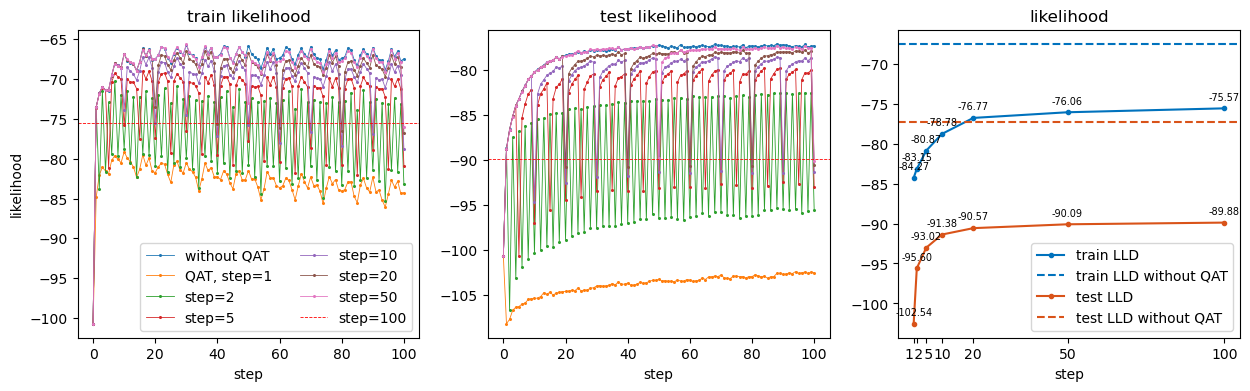

In [85]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

linewidth=0.6
markersize=1.2
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.title("train likelihood")
plt.xlabel("step")
plt.ylabel("likelihood")
plt.plot(step0, train0, label='without QAT', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step1, train1, label='QAT, step=1', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step2, train2, label='step=2', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step5, train5, label='step=5', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step10, train10, label='step=10', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step20, train20, label='step=20', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step50, train50, label='step=50', marker='o', markersize=markersize, linewidth=linewidth)
plt.axhline(y=-75.5681015625, color='r', linestyle='--', label='step=100', linewidth=linewidth)
plt.legend(ncol=2)
# plt.legend(loc='right', bbox_to_anchor=(1, 0.2))

plt.subplot(132)
plt.title("test likelihood")
plt.xlabel("step")
plt.plot(step0, test0, label='without QAT', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step1, test1, label='QAT, step=1', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step2, test2, label='step=2', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step5, test5, label='step=5', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step10, test10, label='step=10', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step20, test20, label='step=20', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step50, test50, label='step=50', marker='o', markersize=markersize, linewidth=linewidth)
plt.axhline(y=-89.87865625, color='r', linestyle='--', label='QAT, step=100', linewidth=linewidth)
# plt.legend(loc='right', bbox_to_anchor=(1, 0.35))


plt.subplot(133)
plt.title("likelihood")
plt.xlabel("step")
plt.xticks([1,2,5,10,20,50,100], ['1  ', ' 2', ' 5', '10', '20', '50', '100'])

plt.plot(step, train, color='#0072BD', label='train LLD', marker='o', markersize=3)
for i in range(len(train)):
    plt.annotate(f'{train[i]:.2f}', (step[i], round(train[i], 2)), textcoords="offset points", xytext=(0,6), fontsize=7, ha='center')
plt.axhline(y=train0[-1], color='#0072BD', linestyle='--', label='train LLD without QAT')

plt.plot(step, test, color='#D95319', label='test LLD', marker='o', markersize=3)
for i in range(len(test)):
    plt.annotate(f'{test[i]:.2f}', (step[i], round(test[i], 2)), textcoords="offset points", xytext=(0,6), fontsize=7, ha='center')
plt.axhline(y=test0[-1], color='#D95319', linestyle='--', label='test LLD without QAT')
plt.legend()

## QAT Kmeans

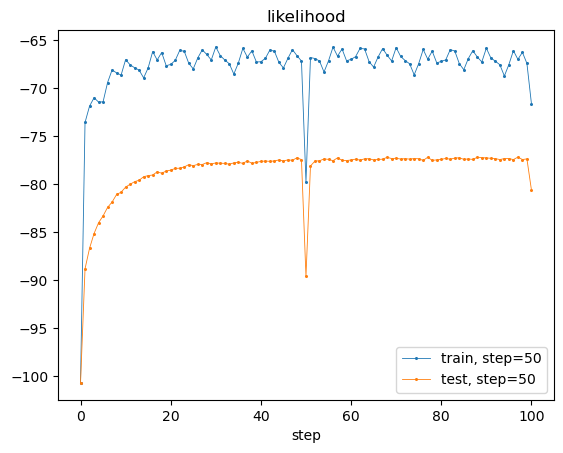

In [3]:
data = '''
0	-1.0	-100.711265625
1	-73.5685859375	-88.817640625
2	-71.868390625	-86.6865390625
3	-70.993859375	-85.1461171875
4	-71.4369921875	-84.0193984375
5	-71.4203125	-83.3052421875
6	-69.4084375	-82.421671875
7	-68.093109375	-81.861578125
8	-68.4015	-81.0745625
9	-68.63059375	-80.835390625
10	-67.0180625	-80.304984375
11	-67.561453125	-80.0080234375
12	-67.8652890625	-79.7365234375
13	-68.1131484375	-79.58878125
14	-68.92359375	-79.221578125
15	-67.877140625	-79.1078828125
16	-66.18721875	-79.0444140625
17	-67.051515625	-78.7139765625
18	-66.277203125	-78.8553828125
19	-67.65028125	-78.62875
20	-67.5194296875	-78.53515625
21	-67.1028125	-78.3572421875
22	-66.06134375	-78.3342265625
23	-66.1437109375	-78.2016875
24	-67.39475	-77.9625859375
25	-67.98384375	-78.069609375
26	-66.8428125	-77.936234375
27	-66.00128125	-77.9498203125
28	-66.47925	-77.753765625
29	-67.054671875	-77.88484375
30	-65.694875	-77.78390625
31	-66.6024375	-77.815
32	-67.0593984375	-77.8311171875
33	-67.45253125	-77.91615625
34	-68.5240625	-77.779015625
35	-67.3725703125	-77.71078125
36	-65.847171875	-77.83675
37	-66.748578125	-77.566390625
38	-66.1042265625	-77.82465625
39	-67.26434375	-77.72996875
40	-67.241796875	-77.6246328125
41	-66.88325	-77.5871484375
42	-66.01340625	-77.62034375
43	-66.14353125	-77.576375
44	-67.30796875	-77.47109375
45	-67.8833984375	-77.584078125
46	-66.8750625	-77.46165625
47	-65.9794921875	-77.513109375
48	-66.604546875	-77.2424375
49	-67.1659375	-77.4417421875
50	-79.7797421875	-89.60875
51	-66.797625	-78.10125
52	-66.9046640625	-77.5846875
53	-67.1595234375	-77.563984375
54	-68.308	-77.3653203125
55	-67.1462421875	-77.413875
56	-65.7121171875	-77.5529375
57	-66.652375	-77.25471875
58	-65.907921875	-77.5079921875
59	-67.139078125	-77.5340859375
60	-66.9881953125	-77.47859375
61	-66.710140625	-77.3889375
62	-65.8417890625	-77.4946875
63	-65.906046875	-77.355265625
64	-67.231875	-77.3471875
65	-67.796765625	-77.473875
66	-66.733625	-77.422859375
67	-65.865390625	-77.3930625
68	-66.55821875	-77.1967890625
69	-67.15953125	-77.3292265625
70	-65.7586953125	-77.2980625
71	-66.69015625	-77.3797421875
72	-67.11453125	-77.3370390625
73	-67.4571484375	-77.3903828125
74	-68.6040625	-77.3281484375
75	-67.4291953125	-77.348671875
76	-65.9604453125	-77.5263125
77	-66.9679375	-77.1916796875
78	-66.13553125	-77.517890625
79	-67.3573046875	-77.465625
80	-67.20315625	-77.421234375
81	-67.043609375	-77.3123125
82	-65.9784921875	-77.397703125
83	-66.118421875	-77.27821875
84	-67.428328125	-77.252171875
85	-68.073109375	-77.407109375
86	-66.908234375	-77.3708359375
87	-66.0874140625	-77.417609375
88	-66.7447578125	-77.19475
89	-67.25671875	-77.2332734375
90	-65.824546875	-77.259671875
91	-66.840890625	-77.303375
92	-67.18296875	-77.33334375
93	-67.5529765625	-77.435796875
94	-68.72546875	-77.329046875
95	-67.53234375	-77.3263828125
96	-66.08340625	-77.43784375
97	-66.989921875	-77.1780859375
98	-66.25734375	-77.430828125
99	-67.4136796875	-77.3644140625
100	-71.5973203125	-80.59446875
'''


def splitdata(data):
    steps = []
    train_lls = []
    test_lls = []
    string_io = io.StringIO(data)
    for line in string_io.readlines():
        line = line.strip()
        if line == "":
            continue
        # print(line, line.split('\t'))
        step, train_ll, test_ll = line.split('\t')
        steps.append(int(step))
        if train_ll == "-1.0":
            train_lls.append(float(test_ll))
        else:
            train_lls.append(float(train_ll))
        test_lls.append(float(test_ll))
    return steps, train_lls, test_lls

step, train, test = splitdata(data)

import matplotlib.pyplot as plt


linewidth=0.6
markersize=1.2
plt.figure()

plt.title("likelihood")
plt.xlabel("step")
plt.plot(step, train, label='train, step=50', marker='o', markersize=markersize, linewidth=linewidth)
plt.plot(step, test, label='test, step=50', marker='o', markersize=markersize, linewidth=linewidth)
plt.legend()
# plt.legend(loc='right', bbox_to_anchor=(1, 0.2))

## ctrlg and pytorch tests

In [1]:
import os
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # set your cuda device
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import torch
import ctrlg
from transformers import AutoModelForCausalLM, AutoTokenizer, LogitsProcessorList
from torchvision import datasets

from ctrlg.mytest import *

In [26]:
# load the pretrained base_model and HMM
BASE_MODEL_PATH = f'ctrlg/gpt2-large_common-gen'
HMM_MODEL_PATH = f'ctrlg/hmm_gpt2-large_common-gen_4096'
# HMM_MODEL_PATH = f'ctrlg/hmm_gpt2-large_common-gen_32768'

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_PATH)
base_model.eval()
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

hmm_model = ctrlg.HMM.from_pretrained(HMM_MODEL_PATH)

vocab_size = hmm_model.vocab_size
eos_token_id = hmm_model.eos_token_id
print("alpha_exp", hmm_model.alpha_exp.shape, hmm_model.alpha_exp)
print("beta", hmm_model.beta.shape, hmm_model.beta)
print("gamma", hmm_model.gamma.shape, hmm_model.gamma)

NameError: name 'AutoModelForCausalLM' is not defined

### pytorch tests

In [22]:
import torch
alpha_flow = torch.rand(2,3)
alpha_flow.div_(torch.sum(alpha_flow, dim=1, keepdim=True))
print(alpha_flow)
# quantization
scale = torch.max(alpha_flow) / 255
alpha_flow.div_(scale).round_().clamp_(0, 255)

print(alpha_flow.mul(scale))
print(alpha_flow)
alpha_flow.div_(torch.sum(alpha_flow, dim=1, keepdim=True))
print(alpha_flow)

tensor([[0.4302, 0.0630, 0.5068],
        [0.0251, 0.5757, 0.3992]])
tensor([[0.4312, 0.0632, 0.5057],
        [0.0248, 0.5757, 0.3996]])
tensor([[191.,  28., 224.],
        [ 11., 255., 177.]])
tensor([[0.4312, 0.0632, 0.5056],
        [0.0248, 0.5756, 0.3995]])


In [85]:
import torch

hidden_states = 4
sequence_length = 6
# 示例张量
beta = torch.randn(hidden_states, sequence_length)  # 4x6
input_ids = torch.tensor([[0,1], [2,3], [0,2]]) # 3x2

print(beta)

# 生成索引
indices = torch.arange(0, hidden_states)[None, :, None] # 1x4x1
input_ids_expanded = input_ids[:, None, :] # 3x1x2
print(indices)
print(input_ids_expanded)

# 索引操作
input_probs = beta[indices, input_ids_expanded]
print(input_probs.shape)

print(input_probs)

tensor([[ 0.5252, -1.4900,  0.7837, -1.4144,  1.6691,  1.2383],
        [-0.2339, -0.1290,  0.0838,  0.3663,  0.5340, -1.0321],
        [-1.3694, -0.8739, -1.1352, -1.5295, -0.1545, -0.4317],
        [ 0.9913, -1.0639,  1.1261,  1.2311,  1.3030,  0.0730]])
tensor([[[0],
         [1],
         [2],
         [3]]])
tensor([[[0, 1]],

        [[2, 3]],

        [[0, 2]]])
torch.Size([3, 4, 2])
tensor([[[ 0.5252, -1.4900],
         [-0.2339, -0.1290],
         [-1.3694, -0.8739],
         [ 0.9913, -1.0639]],

        [[ 0.7837, -1.4144],
         [ 0.0838,  0.3663],
         [-1.1352, -1.5295],
         [ 1.1261,  1.2311]],

        [[ 0.5252,  0.7837],
         [-0.2339,  0.0838],
         [-1.3694, -1.1352],
         [ 0.9913,  1.1261]]])


In [2]:
import torch
alpha_flow = torch.rand(3,4)
alpha_flow.div_(torch.sum(alpha_flow, dim=-1, keepdim=True))
print(alpha_flow)
# alpha_flow = torch.clamp(alpha_flow.mul(255).round(), 0, 255)
# print(alpha_flow)
alpha_flow[1][1] = float('-inf')
# alpha_flow.log_()
print(alpha_flow)
print(torch.softmax(alpha_flow, dim=0))
# alpha_flow.exp_()
print(alpha_flow)

tensor([[0.2470, 0.3906, 0.1878, 0.1746],
        [0.2691, 0.2173, 0.2291, 0.2846],
        [0.3403, 0.1650, 0.2988, 0.1959]])
tensor([[0.2470, 0.3906, 0.1878, 0.1746],
        [0.2691,   -inf, 0.2291, 0.2846],
        [0.3403, 0.1650, 0.2988, 0.1959]])
tensor([[0.3205, 0.5562, 0.3165, 0.3187],
        [0.3277, 0.0000, 0.3298, 0.3558],
        [0.3518, 0.4438, 0.3537, 0.3255]])
tensor([[0.2470, 0.3906, 0.1878, 0.1746],
        [0.2691,   -inf, 0.2291, 0.2846],
        [0.3403, 0.1650, 0.2988, 0.1959]])


In [19]:
input_text = "Once upon"
input_ids = tokenizer.encode(input_text)
input_ids=torch.tensor([input_ids] * 2)
outputs = base_model.generate(
    input_ids=input_ids,
    max_new_tokens=32,
    do_sample=True,
    output_hidden_states=True,
    output_attentions=True,
    output_scores=True,
    return_dict_in_generate=True,
    pad_token_id=tokenizer.eos_token_id,
)

print("sequence", outputs.sequences)
print("scores: ", len(outputs.scores), outputs.scores[0].shape)
print("sentence total length: ", len(outputs.sequences[0]))
print("newly generated length: ", len(outputs.attentions))
print("layer number: ", len(outputs.attentions[0]))


layer = -1
for idx in range(len(outputs.attentions)):
    print(outputs.attentions[idx][layer].shape, outputs.hidden_states[idx][layer].shape)

print("score shape: ", outputs.scores[0].shape)

sequence tensor([[ 7454,  2402,   257,   640,    11,   314, 27947,   257,  1256,   546,
          1016,   284, 36312,   530,  1110,   986, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256],
        [ 7454,  2402,   257,   640,    11,   262,   691,  1738,   284,  4144,
           318,   284,  1254,   922,    13,  2735,   356,   821,  1016,   284,
          1561,   546,  6099, 12186,   326,   389,  6099,  7867,    11,  6099,
          7867,  3186,    11,   290]])
scores:  32 torch.Size([2, 50257])
sentence total length:  34
newly generated length:  32
layer number:  36
torch.Size([2, 20, 2, 2]) torch.Size([2, 2, 1280])
torch.Size([2, 20, 1, 3]) torch.Size([2, 1, 1280])
torch.Size([2, 20, 1, 4]) torch.Size([2, 1, 1280])
torch.Size([2, 20, 1, 5]) torch.Size([2, 1, 1280])
torch.Size([2, 20, 1, 6]) torch.Size([2, 1, 1280])
torch.Size([2, 20, 1, 7]) torch.Size([2, 1, 1280])
torch.Size([2, 20, 1, 8]) 

## Plot Kmeans centroids and parameter distribution 

torch.Size([4096])


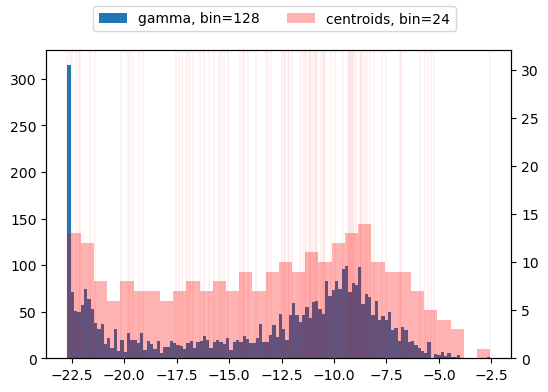

torch.Size([4096, 4096])


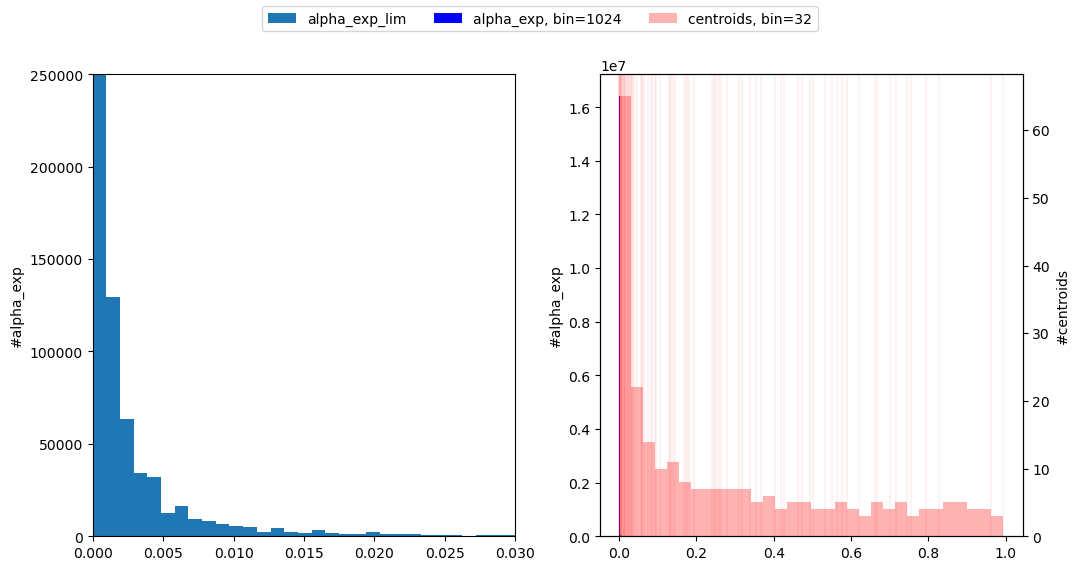

torch.Size([4096, 50257])


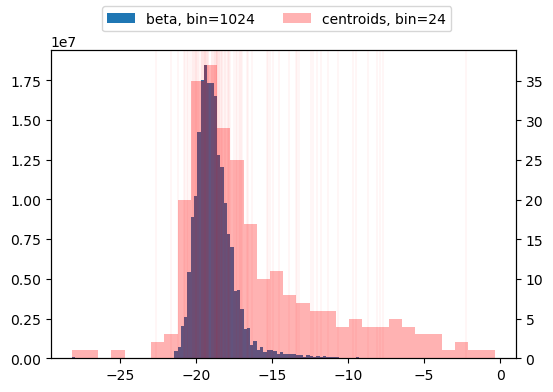

In [28]:
import matplotlib.pyplot as plt
b = 8
alpha_exp = torch.load(f'data/alpha_exp{b}.pt', weights_only=True)
beta = torch.load(f'data/beta{b}.pt', weights_only=True)
gamma = torch.load(f'data/gamma{b}.pt', weights_only=True)
alpha_exp_centroids = torch.load(f'data/alpha_exp{b}centroids.pt', weights_only=True)
beta_centroids = torch.load(f'data/beta{b}centroids.pt', weights_only=True)
gamma_centroids = torch.load(f'data/gamma{b}centroids.pt', weights_only=True)
# print("alpha_exp", hmm_model.alpha_exp.shape, hmm_model.alpha_exp)
# print("beta", hmm_model.beta.shape, hmm_model.beta)
# print("gamma", hmm_model.gamma.shape, hmm_model.gamma)

print(gamma.shape)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(gamma.flatten(), bins=128, label='gamma, bin=128')
# plt.scatter(gamma_centroids, [2]*(2**b), c='r', s=0.2)
ax1 = ax.twinx()
ax1.set_ylim(0,32)
ax1.hist(gamma_centroids.flatten().sort()[0], bins=32, label='centroids, bin=24', color='red', alpha=0.3)
for i in range(0, 2**b, 3):
    ax1.axvline(x=gamma_centroids[i], c='r', linewidth=0.1, alpha=0.7)
fig.legend(loc='upper center', ncol=2)
plt.show()

print(alpha_exp.shape)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.hist(alpha_exp.flatten(), bins=1024, label='alpha_exp_lim')
ax0.set_ylim(0, 2.5e5)
ax0.set_xlim(0, 0.03)
ax0.set_ylabel('#alpha_exp')
ax1.hist(alpha_exp.flatten(), bins=1024, label='alpha_exp, bin=1024', color='blue')
ax1.set_ylabel('#alpha_exp')
ax2 = ax1.twinx()
ax2.hist(alpha_exp_centroids.flatten().sort()[0], bins=32, label='centroids, bin=32', color='red', alpha=0.3)
ax2.set_ylabel('#centroids')
for i in range(0, 2**b, 3):
    ax2.axvline(x=alpha_exp_centroids[i], c='r', linewidth=0.1, alpha=0.7)
fig.legend(loc='upper center', ncol=3)
plt.show()

print(beta.shape)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(beta.flatten(), bins=128, label='beta, bin=1024')
ax1 = ax.twinx()
ax1.hist(beta_centroids.flatten().sort()[0], bins=32, label='centroids, bin=24', color='red', alpha=0.3)
for i in range(0, 2**b, 3):
    ax1.axvline(x=beta_centroids[i], c='r', linewidth=0.1, alpha=0.5)
fig.legend(loc='upper center', ncol=2)
plt.show()

# fig = plt.figure(figsize=(6,4))
# plt.hist(beta.flatten(), bins=512, label='beta')
# # plt.scatter(gamma_centroids, [2]*(2**b), c='r', s=0.2)
# plt.hist(beta_centroids.flatten().sort()[0], bins=24, label='centroids', color='red', alpha=0.5)
# for i in range(0, 2**b, 4):
#     plt.axvline(x=gamma_centroids[i], c='r', linewidth=0.2, alpha=0.7)
# plt.legend()
# plt.show()

## plot scores of different bit width

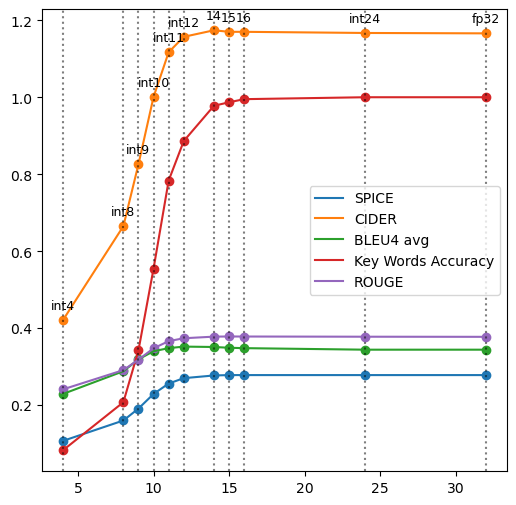

In [30]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['int4', 'int8', 'int9', 'int10', 'int11', 'int12', '14', '15', '16', 'int24', 'fp32']
x = [4, 8, 9, 10, 11, 12, 14, 15, 16, 24, 32]
ROUGE = [0.2409, 0.2909, 0.3182, 0.3476, 0.3662, 0.3737, 0.3779, 0.3783, 0.3782, 0.3777, 0.3774]
SPICE = [0.107, 0.160, 0.191, 0.229, 0.256, 0.270, 0.277, 0.278, 0.278, 0.278, 0.278]
CIDER = [0.421, 0.665, 0.826, 1.001, 1.117, 1.157, 1.174, 1.170, 1.170, 1.167, 1.166]
# CIDER = [i/10 for i in CIDER]
BLEU_avg = [0.229, 0.288, 0.319, 0.340, 0.348, 0.352, 0.351, 0.349, 0.348, 0.344, 0.344]
ACC = [0.0826, 0.2075, 0.3424, 0.5549, 0.7835, 0.8862, 0.9778, 0.9869, 0.9950, 1.0, 1.0]
plt.figure(figsize=(6,6))
plt.plot(x, SPICE, label='SPICE')
plt.plot(x, CIDER, label='CIDER')
plt.plot(x, BLEU_avg, label='BLEU4 avg')
plt.plot(x, ACC, label='Key Words Accuracy')
plt.plot(x, ROUGE, label="ROUGE")
plt.plot[]

plt.scatter(x, SPICE)
plt.scatter(x, CIDER)
plt.scatter(x, BLEU_avg)
plt.scatter(x, ACC)
plt.scatter(x, ROUGE)

for i in x:
    plt.axvline(i, linestyle=':', alpha=0.5, c='black')

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], CIDER[i]), textcoords="offset points", fontsize=9, xytext=(0,8), ha='center')
plt.legend()

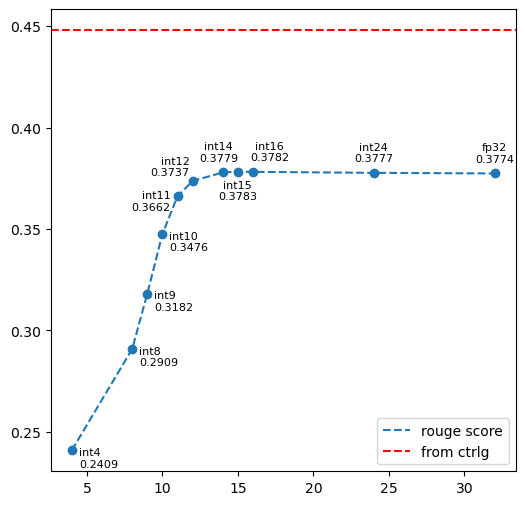

In [57]:
import matplotlib.pyplot as plt
import numpy as np
x = [4, 8, 9, 10, 11, 12, 14, 15, 16, 24, 32]
labels = ['int4', 'int8', 'int9', 'int10', 'int11', 'int12', 'int14', 'int15', 'int16', 'int24', 'fp32']
F = [0.2409, 0.2909, 0.3182, 0.3476, 0.3662, 0.3737, 0.3779, 0.3783, 0.3782, 0.3777, 0.3774]
plt.figure(figsize=(6,6))
plt.plot(x, F, label='rouge score', linestyle='--')
plt.scatter(x, F)

for i, label in enumerate(labels):
    if i in [0, 1, 2, 3]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(5,-12), ha='left')
    elif i in [4, ]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(-5,-10), ha='right')
    elif i in [5, ]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(-2,4), ha='right')
    elif i in [6, ]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(-3,8), ha='center')
    elif i in [7, ]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(0,-20), ha='center')
    elif i in [8, ]:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(12,8), ha='center')
    else:
        plt.annotate(label + '\n' + str(F[i]), (x[i], F[i]), textcoords="offset points", fontsize=8, xytext=(0,8), ha='center')
    
plt.axhline(y=0.448, color='r', linestyle='--', label='from ctrlg')
plt.legend()


## Find quantized points using Kmeans

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
b = 8
r = 2 ** b

alpha_exp, beta, gamma = hmm_model.alpha_exp, hmm_model.beta, hmm_model.gamma
print(alpha_exp.shape, beta.shape, gamma.shape)

shape = gamma.shape
kmeans = KMeans(n_clusters=r, random_state=0).fit(gamma.reshape([-1, 1]))
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
gamma = torch.tensor(centroids[labels]).reshape(shape)
print("gamma", gamma.shape, gamma)
torch.save(gamma, f'data/gamma{b}.pt')
torch.save(torch.tensor(labels), f'data/gamma{b}labels.pt')
torch.save(torch.tensor(centroids), f'data/gamma{b}centroids.pt')
loaded_tensor = torch.load(f'data/gamma{b}.pt')
assert((loaded_tensor == gamma).all())
print("Loaded Tensor:", loaded_tensor)

shape = alpha_exp.shape
kmeans = KMeans(n_clusters=r, random_state=0).fit(alpha_exp.reshape([-1, 1]))
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
alpha_exp = torch.tensor(centroids[labels]).reshape(shape)
print("alpha_exp", alpha_exp.shape, alpha_exp)
torch.save(alpha_exp, f'data/alpha_exp{b}.pt')
torch.save(torch.tensor(labels), f'data/alpha_exp{b}labels.pt')
torch.save(torch.tensor(centroids), f'data/alpha_exp{b}centroids.pt')
loaded_tensor = torch.load(f'data/alpha_exp{b}.pt')
assert((loaded_tensor == alpha_exp).all())
print("Loaded Tensor:", loaded_tensor)

# plt.figure(figsize=(8,4))
# plt.subplot(121)
# plt.hist(gamma, bins=256)
# plt.subplot(122)
# plt.hist(centroids[labels], bins=256)
# plt.scatter(centroids, np.zeros_like(centroids), c='red', marker='x')
# plt.show()


torch.Size([4096, 4096]) torch.Size([4096, 50257]) torch.Size([4096])
gamma torch.Size([4096]) tensor([-10.0206,  -5.3910,  -8.6969,  ...,  -7.0129, -11.9168,  -8.1814],
       dtype=torch.float64)
Loaded Tensor: tensor([-10.0206,  -5.3910,  -8.6969,  ...,  -7.0129, -11.9168,  -8.1814],
       dtype=torch.float64)


/tmp/ipykernel_606466/1469718515.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(f'data/gamma{b}.pt')


alpha_exp torch.Size([4096, 4096]) tensor([[3.3451e-06, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.3451e-06],
        [3.3451e-06, 1.7522e-05, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.0521e-03],
        [3.3451e-06, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.3451e-06],
        ...,
        [3.3451e-06, 4.7600e-05, 3.3451e-06,  ..., 1.3449e-02, 3.3451e-06,
         2.5321e-03],
        [1.7522e-05, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.3451e-06],
        [3.3451e-06, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         9.9396e-01]], dtype=torch.float64)
Loaded Tensor: tensor([[3.3451e-06, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.3451e-06],
        [3.3451e-06, 1.7522e-05, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.0521e-03],
        [3.3451e-06, 3.3451e-06, 3.3451e-06,  ..., 3.3451e-06, 3.3451e-06,
         3.3451e-06],
        ...,
        [3.3451e-06, 4.7600e-

/tmp/ipykernel_606466/1469718515.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(f'data/alpha_exp{b}.pt')


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
b = 8
r = 2 ** b
beta = hmm_model.beta
print("beta_old", beta.shape, beta)

shape = beta.shape
kmeans = KMeans(n_clusters=r, random_state=0).fit(beta.reshape([-1,1]))
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
# print("labels", labels)
# print("centroids", centroids)
beta = torch.tensor(centroids[labels]).reshape(shape)
print("beta_new", beta.shape, beta)
torch.save(beta, f'data/beta{b}.pt')
torch.save(torch.tensor(labels), f'data/beta{b}labels.pt')
torch.save(torch.tensor(centroids), f'data/beta{b}centroids.pt')
loaded_tensor = torch.load(f'data/beta{b}.pt')
assert((loaded_tensor == beta).all())
print("Loaded Tensor:", loaded_tensor)

beta_old Parameter containing:
tensor([[-17.8455, -17.8057, -17.8487,  ..., -17.8488, -17.6941, -17.8486],
        [-20.0322, -20.0193, -20.0415,  ..., -20.0435, -20.0318, -20.0402],
        [-18.6415, -18.6693, -18.6847,  ..., -18.6847, -18.4695, -18.6840],
        ...,
        [-19.0940, -18.9897, -19.1402,  ..., -19.1404, -11.2896, -19.1343],
        [-20.6180, -20.5880, -20.6258,  ..., -20.6258, -20.6245, -20.6256],
        [-28.1645, -28.0956, -28.1928,  ..., -28.1928, -28.1928,   0.0000]]) torch.Size([4096, 50257])
beta_new tensor([[-17.8519, -17.8178, -17.8519,  ..., -17.8519, -17.6962, -17.8519],
        [-20.0399, -20.0153, -20.0399,  ..., -20.0399, -20.0399, -20.0399],
        [-18.6372, -18.6637, -18.6910,  ..., -18.6910, -18.4791, -18.6910],
        ...,
        [-19.0988, -18.9914, -19.1437,  ..., -19.1437, -11.3448, -19.1437],
        [-20.6147, -20.5720, -20.6147,  ..., -20.6147, -20.6147, -20.6147],
        [-28.1865, -28.1865, -28.1865,  ..., -28.1865, -28.1865,  -0.36

/tmp/ipykernel_310620/1466602462.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load('data/beta_8.pt')


## Quantized Matmul Test

In [2]:
# 创建一个 float32 张量
tensor = torch.randn(1, 2, 3, 3)

# 定义量化参数
scale, zero_point = asymq(tensor, -128, 127)
print(f"scale={scale}, zero_point={zero_point}")

# 量化张量到 int8
quantized_tensor = torch.quantize_per_tensor(tensor, scale=scale, zero_point=zero_point, dtype=torch.qint8)

print("量化前的张量：")
print(tensor)

print("量化后的张量：")
print(quantized_tensor.int_repr())

# 将量化张量反量化为 float32
dequantized_tensor = quantized_tensor.dequantize()

print("反量化后的张量：")
print(dequantized_tensor)

scale=0.011692242696881294, zero_point=-6.5280303955078125
量化前的张量：
tensor([[[[-0.1041, -0.6634,  0.1260],
          [-0.1552,  1.3396,  1.3968],
          [ 0.4272, -0.7957, -0.0255]],

         [[-1.4203, -0.1324, -0.7974],
          [ 1.5612, -0.2232, -0.2898],
          [ 1.4449,  0.7357,  0.0643]]]])
量化后的张量：
tensor([[[[ -15,  -63,    5],
          [ -19,  109,  113],
          [  31,  -74,   -8]],

         [[-127,  -17,  -74],
          [ 127,  -25,  -31],
          [ 118,   57,   -1]]]], dtype=torch.int8)
反量化后的张量：
tensor([[[[-0.1052, -0.6665,  0.1286],
          [-0.1520,  1.3446,  1.3914],
          [ 0.4326, -0.7951, -0.0234]],

         [[-1.4148, -0.1286, -0.7951],
          [ 1.5551, -0.2222, -0.2923],
          [ 1.4498,  0.7366,  0.0585]]]])


## Words to phrases

In [79]:
from ctrlg.mytest import concepts2cnf
from transformers import AutoTokenizer

BASE_MODEL_PATH = f'ctrlg/gpt2-large_common-gen'
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)
# concepts = [
#     "field",
#     "look",
#     "stand"
# ]
concepts = [
    "pool",
    "suit",
    "swim"
]
concepts = [
    "shot",
    "game",
    "player"
]
cnf = concepts2cnf(concepts, tokenizer)
print(cnf)
for words in cnf:
    w = []
    for i in words:
        w.append(tokenizer.decode(i))
    print(w)

(((6934,), (2823,)), ((308, 2434), (26713,), (1830,), (7776,), (9106, 395), (983,)), ((1938,), (2137,)))
[' shots', ' shot']
[' gamed', ' gamer', ' games', ' gaming', ' gamest', ' game']
[' players', ' player']


In [5]:
import torch
# torch.set_float32_matmul_precision('high')
# print(torch.log(torch.tensor(1.4e-45)))
# print(torch.nan_to_num(torch.log(torch.tensor(0)), neginf=1e-2))
print(torch.exp(torch.tensor(-103)).log())
# print(torch.tensor(-6e4, dtype=torch.half))
def func(A):
    A = A - torch.max(A)
    A.exp_()
    return A
a = torch.tensor([20., 11., 32.])
print(a)
print(func(a))
print(a)

tensor(-103.2789)
tensor([20., 11., 32.])
tensor([6.1442e-06, 7.5826e-10, 1.0000e+00])
tensor([20., 11., 32.])


## GPU Utilization

In [ ]:
import matplotlib.pyplot as plt

x = [2**i for i in range(9)]
# GPU: Tesla V100-SXM2-32GB
GPU_Utilization = [30.18, 30.84, 32.6, 38.25, 45.3, 55.82, 69.91, 80.63, 87.86]
Est_SM_Efficiency = [29.79, 30.24, 31.94, 37.68, 44.8, 55.64, 69.8, 80.55, 87.79]
Est_Achieved_Occupancy = [78.78, 66.21, 70.76, 67.02, 48.12, 41.83, 36.56, 33.23, 31.37]
# self time
copy_ = [6.3, 9.8, 15.8, 22.3, 31.1, 43.8, 66.4, 75.1, 81.1]
# ratio of symbolic part
# 13.807 / (4892.030 - 4836.159)
# 17.272 / (4302.017 - 4236.855)
# 24.148 / (3391.821 - 3320.179)
# 37.586 / (3590.485 - 3503.716)
# 62.378 / (4243.484 - 4127.354)
# 115.746 / (5492.230 - 5319.749)
# 225.573 / (7529.177 - 7239.712)
# 443.421 / (11896.904 - 11380.545)
# 882.422 / (20712.784 - 19728.371)
Ratio_Sym = [24.7, 26.5, 33.7, 43.3, 53.7, 67.1, 77.9, 85.9, 89.6]

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(x, GPU_Utilization, label='GPU Utilization')
plt.plot(x, Est_SM_Efficiency, label='Est. SM Efficiency')
plt.plot(x, Est_Achieved_Occupancy, label='Est. Achieved Occupancy')
plt.xticks(x)
plt.xlabel('beam_size')
plt.ylabel('ratio')
for i in range(len(x)):
    plt.annotate(f'{GPU_Utilization[i]}', (x[i], GPU_Utilization[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{Est_Achieved_Occupancy[i]}', (x[i], Est_Achieved_Occupancy[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()

plt.subplot(122)
plt.plot(x, copy_, label='copy_ self time')
plt.plot(x, Ratio_Sym, label='Symbolic Ratio')
plt.xticks(x)
plt.xlabel('beam_size')
plt.ylabel('ratio')
for i in range(len(x)):
    plt.annotate(f'{copy_[i]}', (x[i], copy_[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{Ratio_Sym[i]}', (x[i], Ratio_Sym[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()

plt.savefig('fig/utilsgpu.png')
plt.close()